# pset09: the return of the ten Arcs
*by Xingyu (Luna) Li , Nov 9th, 2021*
  
## Background
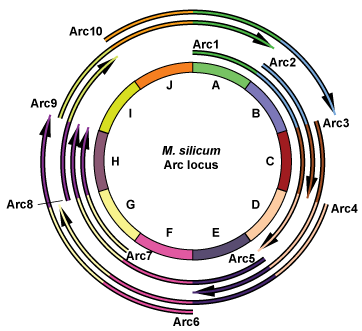
  
The sand mouse Arc locus consists of ten segments A-J. Starting at each segment, it is transcribed into ten overlapping mRNA transcripts, Arc1-Arc10, each of which is 2-4 segments long. 
  
Now we want to estimate the abundance of the individual Arc mRNA isoforms by RNA-seq. There are just 10 different read "sequences" a..j, corresponding to which segment A..J the read maps to and we'll also assume that there is no mismapping (no basecalling error). We are given read counts r_k for reads k=(a,b,c...j), and we're going to use expectation maximization to estimate the unknown abundances of the 10 Arc mRNA isoforms.

## 1. Write a Simulator as a Positive Control

First, we are going to write a function that simulates N=1000000 observed read counts, following our probability model, for any Arc locus structure (i.e. lengths Li) and any transcript abundances τ. 

In [1]:
# Define the simulator function
import numpy as np
def simulator(N, L, nu, T = 10, S = 10):
    reads = np.zeros(S)        # initialize the read counts
    for i in range(T):         # for each transcript
        for j in range(L[i]):  # for each segment
            k = i + j
            if k >= S:
                k -= S
            reads[k] += N * nu[i] * (1/L[i]) # assign read counts to possible segments uniformly
    return reads.astype(int)

Since we've got an example data file, we cound use its parameters and check if our results are similar to the example simulator.

In [2]:
# Define the function to read the data
import string
import sys
import re
def read_data(infile):
    with open(infile) as f:
        line  = f.readline()
        match = re.search(r'^The (\d+) transcripts', line)
        T     = int(match.group(1))
        tau       = np.zeros(T)
        L         = np.zeros(T).astype(int)
        tau_known = True   
        for i in range(T):
            fields    = f.readline().split()
            if fields[1] == "xxxxx":
                tau_known = False
            else:
                tau[i] = float(fields[1])
            L[i]      = int(fields[2])
            
        line  = f.readline()
        line  = f.readline()
        match = re.search(r'The (\d+) read sequences', line)
        N     = int(match.group(1))

        r = np.zeros(T).astype(int)
        for k in range(T):
            fields = f.readline().split()
            r[k]   = fields[1]

    S = T    # S = R = T : there are T transcripts (Arc1..Arc10), S segments (A..J), R reads (a..j)
    return N, L, tau, T, S, r

In [3]:
# Read the example file
N, L, tau, T, S, r = read_data("w09-example.out")
nu = tau * L   # convert to nucleotide abundance
nu = np.divide(nu,sum(nu))

# Use the example parameters to generate a test data set
reads = simulator(N, L, nu, T, S)

# Compare the results
print("  our simulator    vs   example simulator")
for i in range(len(reads)):
    print("{0:15.0f}      {1:15.0f}".format(reads[i],r[i]))

  our simulator    vs   example simulator
         101674               101808
         183014               183489
         186204               186342
          86523                86295
          93301                92872
          49043                48564
          15948                15523
          87320                87426
         113636               113901
          83333                83780


We can see that the read counts our simulator generated are very similar to the example, proving that it's working properly and we can then use it as a positive control for our analysis.

## 2. Calculate the Log Likelihood

Next, we want to write a function that calculates the log likelihood, which is the log probability of the observed data (the observed read counts rk) if the model and its parameters were known (i.e. τ,L), for a given locus structure of Arc.

In [4]:
# Define the log likelihood calculation function
from scipy.special import logsumexp
def lll(reads, L, nu, T, S):
    lll = np.zeros(S)      # initialize the log likelihood
    for i in range(T):         # for each transcript
        for j in range(L[i]):  # for each segment
            k = i + j
            if k >= S:     # for the circulated Arc structure
                k -= S
            lll[k] += nu[i] * 1/L[i]  # sum P(G∣θ) * P(S∣G) over each trancscripts
    for i in range(S):                # for each reads
        lll[i] = np.log(lll[i])       # take the log
        lll[i] *= reads[i]            # sum the log likelihood
    lll_total = sum(lll)              # sum over each reads
    return lll_total

In [5]:
# Calculate the log likelihood of our generated test data
lll_em = lll(reads, L, nu, T, S)
print("The log likelihood of our generated test data is: {0:10.2f}.".format(lll_em))

The log likelihood of our generated test data is: -2170235.35.


In [6]:
# Lestrade's approach to estimate abundances

# Count how often each segment A..J is used in the isoforms i
def seg_count(L,T,S):
    segusage = np.zeros(S).astype(int)
    for i in range(T):
        for j in range(i,i+L[i]): 
            segusage[j%S] += 1
    return segusage
segusage = seg_count(L,T,S)

c  = np.zeros(T)
for i in range(T):
    for k in range(i,i+L[i]):
        c[i] += (1.0 / float(segusage[k%S])) * float(reads[k%S])   
Z       = np.sum(c)
nu_Les  = np.divide(c, Z)       # nucleotide abundance
tau_Les = np.divide(nu_Les, L)  # transcript abundance
tau_Les = np.divide(tau_Les, np.sum(tau_Les))

# Compare his estimates with our true simulated tau
print("     Lestrade's tau    vs    true tau   ")
for i in range(len(tau)):
    print("{0:15.4f}      {1:15.4f}".format(tau_Les[i],tau[i]))

     Lestrade's tau    vs    true tau   
         0.1399               0.0460
         0.1646               0.2930
         0.1216               0.1280
         0.0809               0.0890
         0.0470               0.0170
         0.0453               0.0170
         0.0460               0.0060
         0.1149               0.1960
         0.1180               0.0890
         0.1217               0.1200


In [7]:
lll_Les = lll(reads, L, nu_Les, T, S)
print("The log likelihood of Lestrade's results is: {0:10.2f}.".format(lll_Les))

The log likelihood of Lestrade's results is: -2204801.96.


Results show that Lestrade's estimates of abundances of each Arc isoform in our test data set is far from the true $\tau$, and his log likelihood (-2204801.96) is also worse than ours (-2170235.35) using the known parameters.

## 3. Estimate Isoform Abundances by EM

In order to improve Lestrade's approach, we decide to use expectation maximization to estimate unknown isoform abundances $\tau_i$ for each isoform Arc1..Arc10.

In [8]:
# Initialization: make a guess for the unknown parameters
def initialization(T):
    tau = np.random.dirichlet(np.ones(T)) # use the Dirichlet distribution
    return tau

# Expectation: infer the latents, given the observed data and the guessed parameters
def expectation(reads, L, nu, T, S):
    prob = np.zeros((sum(reads),len(nu)))# initialize the probabilities
    for i in range(len(reads)):           # for each read
        for j in range(sum(reads[0:i]),reads[i]):
            for k in range(len(nu)):     # for each read class
                prob[j][k] = np.log(nu[k]/L[k]) # calculate the numerator
    prob = np.subtract(prob, logsumexp(prob)) # normalize for the denominator
    return prob

# Maximization: given the probabilities of the latents, estimate the parameters through maximum likelihood
def maximization(prob, L):
    reads_new = np.zeros(len(prob[0]))  # initialize the read counts
    for i in range(len(prob)):      # iterate through each read
        for j in range(len(reads_new)): # iterate through each read class
            reads_new[j] += np.exp(prob[i][j])  # sum the probabilities 
    nu = np.divide(reads_new, sum(reads_new))   # calculate the nucleotide abundance
    return nu

In [9]:
# Iterate through each step
import math
def EM(reads, L, T, S, epsilon = 0.01):
    tau = initialization(T)
    nu = tau * L   # convert to nucleotide abundance
    nu = np.divide(nu,sum(nu))
    lll_new = 0
    lll_old = lll(reads, L, nu, T, S)
    lll_list = [lll_old]
    while np.abs(lll_new - lll_old) > epsilon:
        lll_old = lll(reads, L, nu, T, S)
        prob = expectation(reads, L, nu, T, S)
        nu = maximization(prob, L)
        lll_new = lll(reads, L, nu, T, S)
        lll_list.append(lll_new)
    return nu,lll_list

In [10]:
# Use our generated data to test the EM algorithm
L = [2,3,3,4,2,3,3,2,4,1]
nu = [0.1,0.12,0.12,0.07,0.12,0.08,0.13,0.05,0.1,0.09]
tau = np.divide(nu, L)
np.random.seed(9)
reads_test = simulator(N = 1000000, L = L, nu = nu, T = 10, S = 10)
nu_test, lll_test = EM(reads_test, L, T, S, epsilon = 0.001)
tau_test = np.divide(nu_test, L)   # convert to transcript abundance
print("    EM-estimated tau    vs    true tau   ")
for i in range(len(tau)):
    print("{0:15.4f}      {1:15.4f}".format(tau_test[i],tau[i]))
print("The log likelihood of our EM-estimated tau is: {}.".format(lll_test[-1]))

    EM-estimated tau    vs    true tau   
         0.0500               0.0500
         0.0333               0.0400
         0.0333               0.0400
         0.0249               0.0175
         0.0500               0.0600
         0.0333               0.0267
         0.0333               0.0433
         0.0500               0.0250
         0.0249               0.0250
         0.1008               0.0900
The log likelihood of our EM-estimated tau is: -2251985.6857651384.


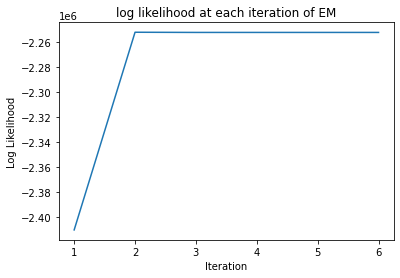

In [11]:
# Visualize the log likelihood at each iteration
import matplotlib.pyplot as plt
i = range(1,len(lll_test)+1)
plt.plot(i, lll_test)
plt.xlabel("Iteration") 
plt.ylabel("Log Likelihood")  
plt.title("log likelihood at each iteration of EM")  
plt.show()

By using our simulator as a positive control, we can see that our EM algorithm works pretty well on the estimation of $\tau$ for each transcript.   
Therefore, we could use it to further analyze Lestrade's data and compare our results with his.

In [12]:
# Read Lestrade's supplementary data
N, L, tau, T, S, r = read_data("w09-data.out")

# Use expectation maximization to calculate tau
np.random.seed(99)
nu_result, lll_result = EM(reads, L, T, S, epsilon = 0.001)
tau_result = np.divide(nu_result, L)   # convert to transcript abundance

# Print the result
print("Transcript  EM-estimated tau ")
Tlabel   = [ "Arc{}".format(d) for d in range(1,T+1) ]    # ['Arc1'..'Arc10'] 
for i in range(T):
    print ("{0:10s}  {1:5.4f}".format(Tlabel[i], tau_result[i]))
print("The log likelihood of our EM-estimated tau is: {}.".format(lll_result[-1]))

Transcript  EM-estimated tau 
Arc1        0.0249
Arc2        0.0502
Arc3        0.0333
Arc4        0.0249
Arc5        0.0249
Arc6        0.0333
Arc7        0.0502
Arc8        0.0502
Arc9        0.0333
Arc10       0.0333
The log likelihood of our EM-estimated tau is: -2333335.4613194256.


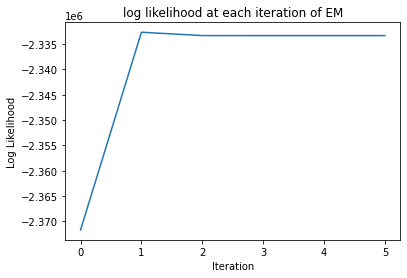

In [13]:
# Visualize the log likelihood at each iteration
import matplotlib.pyplot as plt
i = range(len(lll_result))
plt.plot(i, lll_result)
plt.xlabel("Iteration") 
plt.ylabel("Log Likelihood")  
plt.title("log likelihood at each iteration of EM")  
plt.show()

Our results show that **Arc2, Arc7 and Arc8** are the most abundant transcripts, and **Arc1, Arc4 and Arc5** are the least abundant transcripts.

Lestrade's analysis is similar to the 'rescue' methods decribed in [Mortazavi A, et al.'s 2008 paper](https://www.nature.com/articles/nmeth.1226?report=reader), in which each read is assigned to its cognate segment, and read counts are assigned to possible isoforms uniformly.  
   
In contrast to the rescue methods, our EM algorithm treats mapping uncertainty in a statistically rigorous manner. Using a generative model of RNA-Seq data, we unify the notions of gene and isoform multireads through latent random variables representing the true mappings.  
  
Since the rescue stategy only divides the reads counts evenly among all segments arbitrarily, it can be thought of as a single iteration of the EM algorithm with initial parameters. Without the ability of iterative optimization, the poor performance of Lestrade's method is to be expected.